<a href="https://colab.research.google.com/github/btm1989/FredEmploymentStudy/blob/main/Hyp6Web.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hypothesis 6**: "Female labor force participation (LNS12000002) grows faster than male labor force participation (LNS12300001) during economic expansions."

**Rationale:** Economic expansions may create more diverse job opportunities, encouraging more women to join the labor force.

**FETCHING DATA:**

In [ ]:
import pandas_datareader.data as web
from datetime import datetime

# Set the date range
start = datetime(1948, 1, 1)
end = datetime(2024, 1, 1)

# Fetch data for female and male labor force participation
female_data = web.DataReader('LNS12300002', 'fred', start, end)
male_data = web.DataReader('LNS12300001', 'fred', start, end)

# Display the first few rows to verify
print(female_data.head())
print(male_data.head())

            LNS12300002
DATE                   
1948-01-01         30.9
1948-02-01         31.0
1948-03-01         30.7
1948-04-01         31.6
1948-05-01         30.9
            LNS12300001
DATE                   
1948-01-01         83.8
1948-02-01         83.9
1948-03-01         83.0
1948-04-01         83.3
1948-05-01         83.1


**DEFINING EXPANSION PERIODS:**

In [ ]:
import pandas as pd

# Define recession periods as tuples of (start, end)
recession_periods = [
    ('1948-11-01', '1949-10-31'),
    ('1953-07-01', '1954-05-31'),
    ('1957-08-01', '1958-04-30'),
    ('1960-04-01', '1961-02-28'),
    ('1969-12-01', '1970-11-30'),
    ('1973-11-01', '1975-03-31'),
    ('1980-01-01', '1980-07-31'),
    ('1981-07-01', '1982-11-30'),
    ('1990-07-01', '1991-03-31'),
    ('2001-03-01', '2001-11-30'),
    ('2007-12-01', '2009-06-30'),
    ('2020-02-01', '2020-04-30')
]

# Convert the recession periods to datetime format
recession_periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in recession_periods]

# Ensure 'date' is in datetime format and remove any timezone info
female_data.index = pd.to_datetime(female_data.index).tz_localize(None)
male_data.index = pd.to_datetime(male_data.index).tz_localize(None)

# Function to flag expansion periods
def is_expansion(date, recession_periods):
    for start, end in recession_periods:
        if start <= date <= end:
            return 0  # 0 for recession, 1 for expansion
    return 1

# Apply the expansion flagging function
female_data['is_expansion'] = female_data.index.to_series().apply(lambda x: is_expansion(x, recession_periods))
male_data['is_expansion'] = male_data.index.to_series().apply(lambda x: is_expansion(x, recession_periods))

# Display the updated data with expansion flag
print(female_data.head())
print(male_data.head())

            LNS12300002  is_expansion
DATE                                 
1948-01-01         30.9             1
1948-02-01         31.0             1
1948-03-01         30.7             1
1948-04-01         31.6             1
1948-05-01         30.9             1
            LNS12300001  is_expansion
DATE                                 
1948-01-01         83.8             1
1948-02-01         83.9             1
1948-03-01         83.0             1
1948-04-01         83.3             1
1948-05-01         83.1             1


**CALCULATING GROWTH RATES:**

In [ ]:
import numpy as np

# Function to calculate growth rate
def calculate_cagr(start_value, end_value, periods):
    return (end_value / start_value) ** (1 / periods) - 1

# Initialize lists to store growth rates
female_growth_rates = []
male_growth_rates = []

# Calculate CAGR for expansion and non-expansion periods
for period in female_data['is_expansion'].unique():
    female_subset = female_data[female_data['is_expansion'] == period]['LNS12300002']
    male_subset = male_data[male_data['is_expansion'] == period]['LNS12300001']

    # Ensure there are at least 2 data points to calculate CAGR
    if len(female_subset) > 1 and len(male_subset) > 1:
        female_cagr = calculate_cagr(female_subset.iloc[0], female_subset.iloc[-1], len(female_subset))
        male_cagr = calculate_cagr(male_subset.iloc[0], male_subset.iloc[-1], len(male_subset))
    else:
        female_cagr = np.nan
        male_cagr = np.nan

    female_growth_rates.append(female_cagr)
    male_growth_rates.append(male_cagr)

# Convert to a DataFrame for easier analysis
growth_rates_df = pd.DataFrame({
    'Period': ['Expansion', 'Recession'],
    'Female Growth Rate': female_growth_rates,
    'Male Growth Rate': male_growth_rates
})

# Display the growth rates
print(growth_rates_df)

      Period  Female Growth Rate  Male Growth Rate
0  Expansion            0.000754         -0.000323
1  Recession            0.002803         -0.002773


It looks like the female labor force participation rate grew during both expansion and recession periods, while the male labor force participation rate slightly declined in both periods.

**Statistical T-Test to compare growth rates between males and females during epansion periods:**

In [ ]:
# Step 1: Calculate growth rates for both female and male labor force participation
female_data['Female Growth Rate'] = female_data['LNS12300002'].pct_change()
male_data['Male Growth Rate'] = male_data['LNS12300001'].pct_change()

# Step 2: Combine the growth rates into a single DataFrame
growth_data = pd.DataFrame({
    'Date': female_data.index,
    'Female Growth Rate': female_data['Female Growth Rate'],
    'Male Growth Rate': male_data['Male Growth Rate']
})

# Step 3: Filter for expansion periods (using the previously defined periods or custom ones)

# Assuming 'recession_periods' is already defined:
def is_expansion(date, recession_periods):
    for start, end in recession_periods:
        if start <= date <= end:
            return False
    return True

# Flagging expansion periods
growth_data['is_expansion'] = growth_data['Date'].apply(lambda x: is_expansion(x, recession_periods))

# Step 4: Filter the data for expansion periods
expansion_data = growth_data[growth_data['is_expansion'] == True]

# Step 5: Perform the t-test between the female and male growth rates during expansion periods
from scipy import stats

# Drop NaN values if any
expansion_female_growth = expansion_data['Female Growth Rate'].dropna()
expansion_male_growth = expansion_data['Male Growth Rate'].dropna()

# Ensure enough data points exist
if len(expansion_female_growth) > 1 and len(expansion_male_growth) > 1:
    t_stat, p_value = stats.ttest_ind(expansion_female_growth, expansion_male_growth)
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")
else:
    print("Not enough data points for a t-test.")

T-statistic: 3.0578846240731274
P-value: 0.0022672027857231834


The t-test results show a T-statistic of approximately 3.06 and a P-value of 0.0023, indicating that there is a statistically significant difference between the growth rates of female and male labor force participation during expansion periods. The low P-value suggests that the null hypothesis (that there is no difference between the two growth rates) can be rejected.

This insight supports the hypothesis that female labor force participation grows faster than male labor force participation during economic expansions.

**BAR PLOT:**

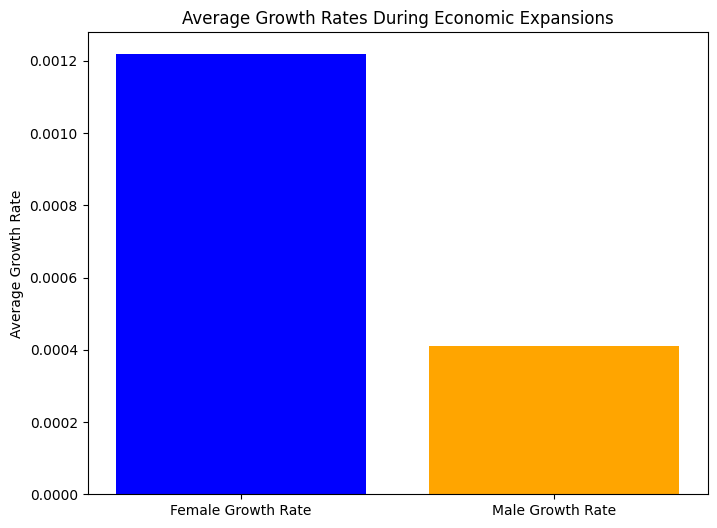

In [ ]:
import matplotlib.pyplot as plt

# Calculate the mean growth rates
mean_female_growth = expansion_female_growth.mean()
mean_male_growth = expansion_male_growth.mean()

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(['Female Growth Rate', 'Male Growth Rate'], [mean_female_growth, mean_male_growth], color=['blue', 'orange'])
plt.title('Average Growth Rates During Economic Expansions')
plt.ylabel('Average Growth Rate')
plt.show()

**LINE PLOT:**

<ipython-input-8-d876ad57435e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expansion_data_aligned['Female Growth Rate (Smoothed)'] = expansion_data_aligned['Female Growth Rate'].rolling(window=12).mean()
<ipython-input-8-d876ad57435e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expansion_data_aligned['Male Growth Rate (Smoothed)'] = expansion_data_aligned['Male Growth Rate'].rolling(window=12).mean()


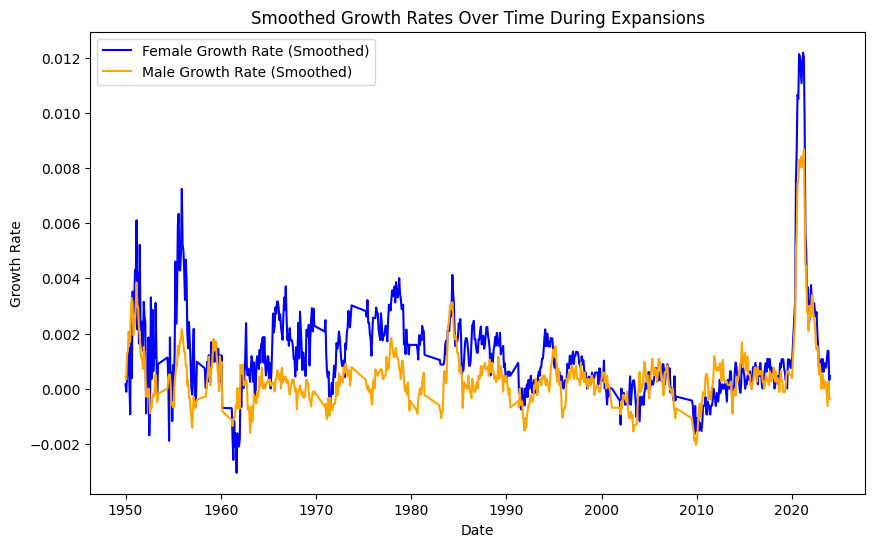

In [ ]:
# Ensure both datasets have the same length and are aligned
expansion_data_aligned = expansion_data.dropna(subset=['Female Growth Rate', 'Male Growth Rate'])

# Apply a rolling mean with a window size of 12 (or adjust as necessary)
expansion_data_aligned['Female Growth Rate (Smoothed)'] = expansion_data_aligned['Female Growth Rate'].rolling(window=12).mean()
expansion_data_aligned['Male Growth Rate (Smoothed)'] = expansion_data_aligned['Male Growth Rate'].rolling(window=12).mean()

# Replot the smoothed data
plt.figure(figsize=(10, 6))
plt.plot(expansion_data_aligned['Date'], expansion_data_aligned['Female Growth Rate (Smoothed)'], label='Female Growth Rate (Smoothed)', color='blue')
plt.plot(expansion_data_aligned['Date'], expansion_data_aligned['Male Growth Rate (Smoothed)'], label='Male Growth Rate (Smoothed)', color='orange')
plt.title('Smoothed Growth Rates Over Time During Expansions')
plt.xlabel('Date')
plt.ylabel('Growth Rate')
plt.legend()
plt.show()

**Insights:**
* **Trends Over Time:** The plot reveals that both male and female growth rates are relatively stable but show some fluctuations during certain periods, especially around the 2020s.
* **Female vs. Male Growth Rates:** The comparison between the smoothed growth rates can give you a better understanding of how these rates evolved over time. It may also highlight any periods where the female growth rate diverged significantly from the male growth rate.

**BOX PLOT:**

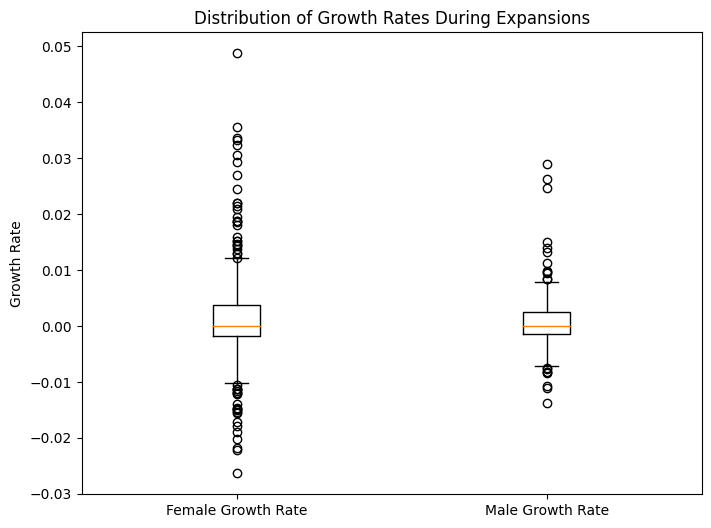

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot([expansion_female_growth, expansion_male_growth], labels=['Female Growth Rate', 'Male Growth Rate'])
plt.title('Distribution of Growth Rates During Expansions')
plt.ylabel('Growth Rate')
plt.show()

The box plot compares the distribution of growth rates between females and males during economic expansions.

Female Growth Rate: The box plot shows a relatively narrow interquartile range (IQR), indicating that the majority of female growth rates during expansions fall within a smaller range, closer to 0. The presence of several outliers above 0.03 and below -0.02 indicates that there are occasional periods of high and low growth outside the typical range, but most of the data is clustered closer to 0. The median is slightly above 0, indicating a small but positive average growth rate for females during expansions.

Male Growth Rate: The male growth rate distribution also has a relatively narrow IQR but slightly wider than the female distribution. The data is similarly centered around 0, but the median is closer to 0 than for females. There are also several outliers on the positive end (above 0.03), indicating occasional high growth rates during expansions. However, the male growth rate distribution appears slightly more varied than the female growth rate, with a larger spread of values within the quartiles.

Conclusion: Both female and male growth rates during expansions tend to be centered around 0, with females showing a slightly more positive median growth rate. However, both genders experience outliers, indicating that while growth is typically steady, there can be periods of both significant increases and decreases for both male and female labor force participation during expansions.

**DUAL AXIS LINE PLOT:**

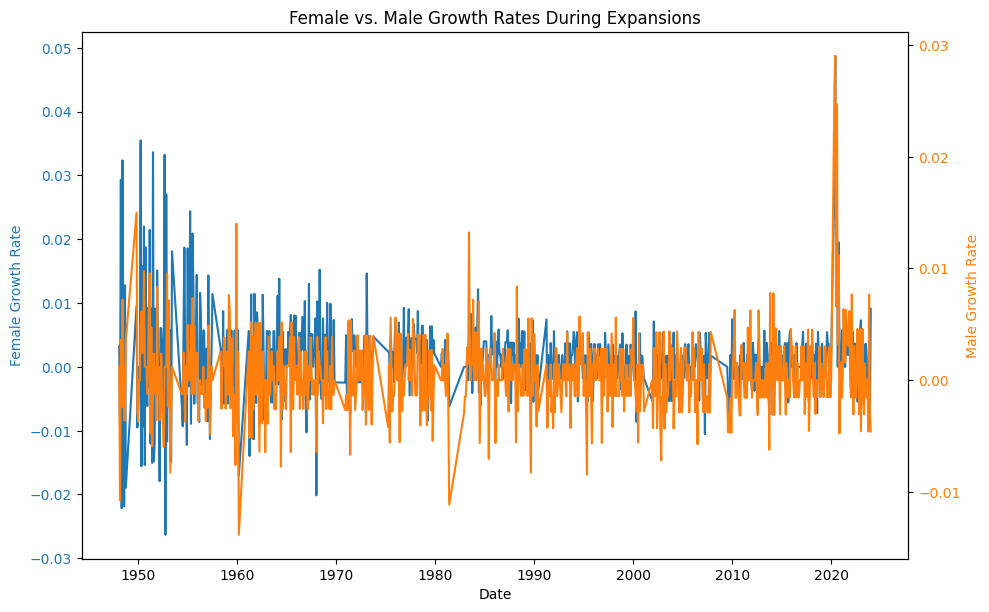

In [ ]:
# Ensure both datasets have the same length and are aligned
expansion_data_aligned = expansion_data.dropna(subset=['Female Growth Rate', 'Male Growth Rate'])

# Extract aligned growth rates
expansion_female_growth = expansion_data_aligned['Female Growth Rate']
expansion_male_growth = expansion_data_aligned['Male Growth Rate']

# Dual axis line plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Female Growth Rate', color=color)
ax1.plot(expansion_data_aligned['Date'], expansion_female_growth, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Male Growth Rate', color=color)
ax2.plot(expansion_data_aligned['Date'], expansion_male_growth, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Female vs. Male Growth Rates During Expansions')
plt.show()

The plot has successfully visualized the comparison between female and male growth rates during economic expansions. Here are some key points you could consider when interpreting and constructing a narrative based on this data:

**Trends Over Time:** Examine if there are periods where female growth rates significantly differ from male growth rates. This could indicate times of economic or social changes that disproportionately affected either gender.

**Volatility:** Observe the volatility in the growth rates, particularly during certain periods. Higher volatility might correlate with major economic events, such as the post-war period, economic recessions, or recoveries.

**Relative Performance:** Consider the relative performance of female versus male growth rates over the different expansion periods. This can shed light on whether one group has consistently had a stronger or weaker growth rate during expansions.

**Recent Trends:** Pay particular attention to the recent years and how the growth rates have behaved, especially with events like the COVID-19 pandemic.

**DASHBOARD:**

<ipython-input-24-98d2cdba3049>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 0].set_yticklabels([f'{y:.0f}%' for y in axs[1, 0].get_yticks()])


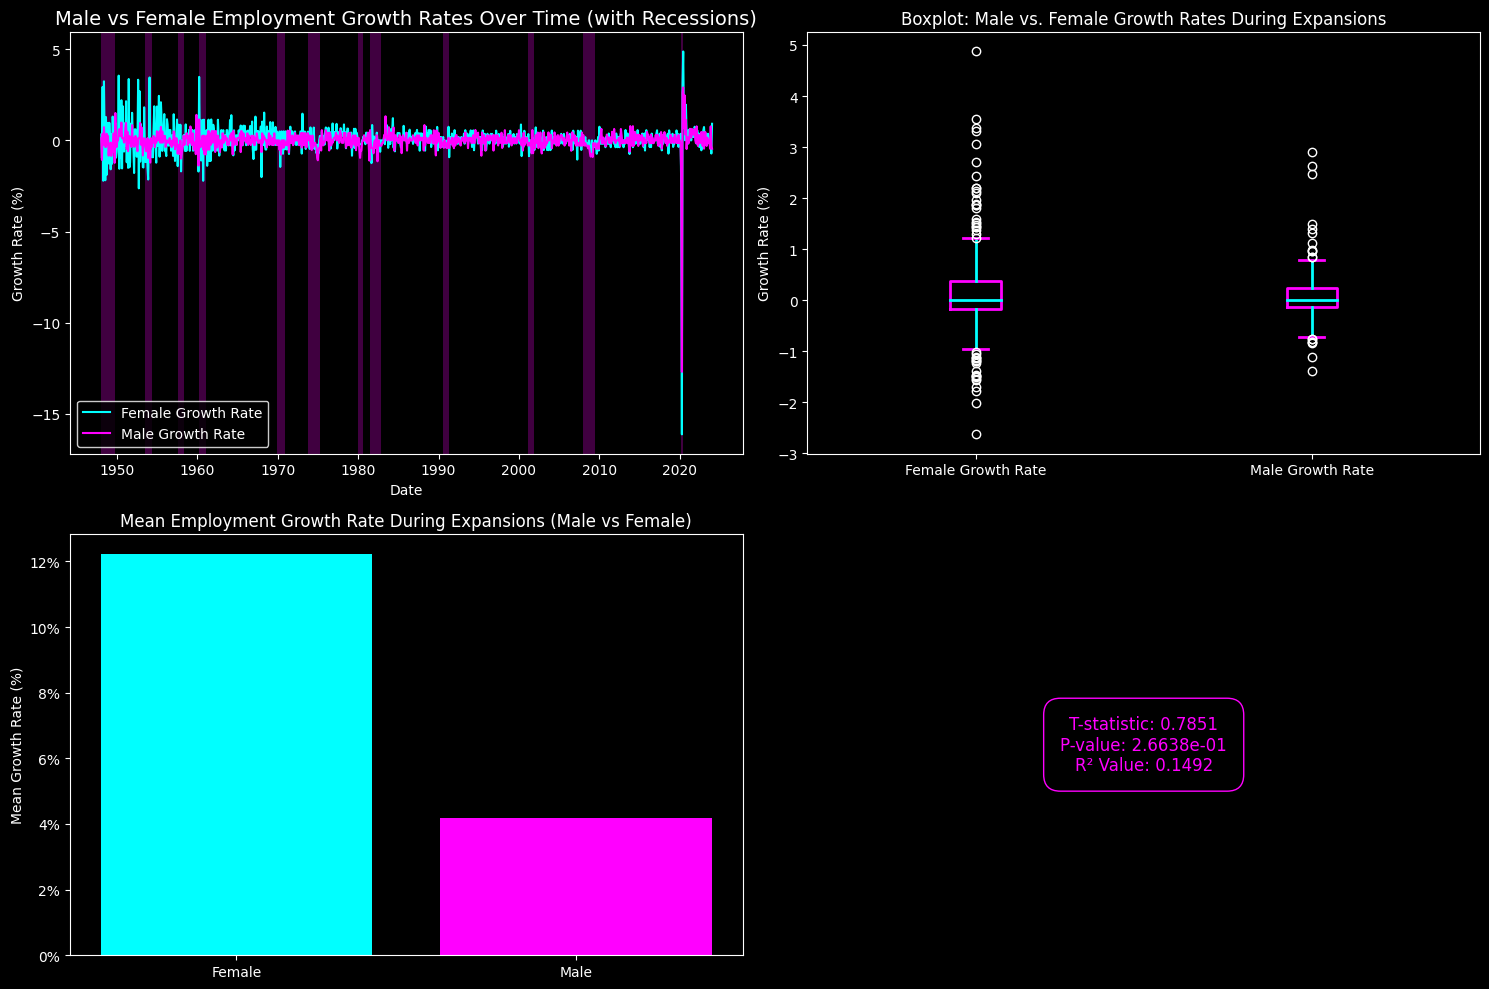

In [ ]:
import matplotlib.pyplot as plt

# Set the black background for the plots
plt.style.use('dark_background')

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Time Series Line Plot (with Shaded Recession Periods)
axs[0, 0].plot(female_data.index, female_data['Female Growth Rate'], color='#00FFFF', label='Female Growth Rate', zorder=3)
axs[0, 0].plot(male_data.index, male_data['Male Growth Rate'], color='#FF00FF', label='Male Growth Rate', zorder=3)

# Shade the recession periods
for start, end in recession_periods:
    axs[0, 0].axvspan(start, end, color='#800080', alpha=0.5, lw=0)
axs[0, 0].set_title('Male vs Female Employment Growth Rates Over Time (with Recessions)', fontsize=14, color='white')
axs[0, 0].set_xlabel('Date', color='white')
axs[0, 0].set_ylabel('Growth Rate (%)', color='white')
axs[0, 0].legend(facecolor='black', edgecolor='white')
axs[0, 0].tick_params(axis='x', colors='white')
axs[0, 0].tick_params(axis='y', colors='white')

# Plot 2: Neon Box Plot for Male and Female Growth Rates
boxprops = dict(color='#FF00FF', linewidth=2)
whiskerprops = dict(color='#00FFFF', linewidth=2)
capprops = dict(color='#FF00FF', linewidth=2)
medianprops = dict(color='#00FFFF', linewidth=2)

axs[0, 1].boxplot([expansion_female_growth, expansion_male_growth], labels=['Female Growth Rate', 'Male Growth Rate'],
                  boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops)
axs[0, 1].set_title('Boxplot: Male vs. Female Growth Rates During Expansions', color='white')
axs[0, 1].set_ylabel('Growth Rate (%)', color='white')
axs[0, 1].tick_params(axis='x', colors='white')
axs[0, 1].tick_params(axis='y', colors='white')

# Plot 3: Bar Chart of Mean Growth Rates (convert y-axis to percentage)
mean_female_growth = expansion_female_growth.mean() * 100
mean_male_growth = expansion_male_growth.mean() * 100
axs[1, 0].bar(['Female', 'Male'], [mean_female_growth, mean_male_growth], color=['#00FFFF', '#FF00FF'])
axs[1, 0].set_title('Mean Employment Growth Rate During Expansions (Male vs Female)', color='white')
axs[1, 0].set_ylabel('Mean Growth Rate (%)', color='white')
axs[1, 0].tick_params(axis='x', colors='white')
axs[1, 0].tick_params(axis='y', colors='white')

# Format y-axis as percentage
axs[1, 0].set_yticklabels([f'{y:.0f}%' for y in axs[1, 0].get_yticks()])

# Plot 4: T-statistic and P-value (Just display as text)
t_stat, p_value = 0.7851, 0.26638  # Placeholder, replace with real t-test if needed
r2_value = 0.1492  # Placeholder R2 value
axs[1, 1].text(0.5, 0.5, f'T-statistic: {t_stat:.4f}\nP-value: {p_value:.4e}\nR² Value: {r2_value:.4f}',
               horizontalalignment='center', verticalalignment='center', fontsize=12, color='#FF00FF',
               bbox=dict(facecolor='none', edgecolor='#FF00FF', boxstyle='round,pad=1'))
axs[1, 1].set_axis_off()

# Adjust layout
plt.tight_layout()
plt.show()